In [6]:
using Revise
using NonEqDigits

In [22]:
using GLMakie
using CairoMakie
using JLD2
using GraphvizDotLang: attr
using GraphvizDotLang
using ColorSchemes

In [8]:
includet("../scripts/ma_colors.jl")
single_col_width = 324 # corresponds to 3+3/8 in as state in PR guidelines
double_col_width = single_col_width*2
golden_ratio = 1.618
nothing

# Version 2

## Setup

In [9]:
using GillespieSim
function run_gs_for_kymo2(ma, start_state, num_steps=10; maxtime=nothing, kwargs...)
    gs = Gillespie(ma, 0., start_state);
    
    vs = [gs.cur_state]
    ts = [gs.cur_time]

    finished_in_ssac = false

    for i in 1:num_steps
        ns = GillespieSim.next_step(gs)
        if isnothing(ns)
            finished_in_ssac = true
            break
        end

        (dt, nstate) = ns
        gs.cur_time += dt
        gs.cur_state = nstate

        push!(ts, gs.cur_time)
        push!(vs, gs.cur_state)
        
        if !isnothing(maxtime) && (gs.cur_time >= maxtime)
            break
        end
    end

    if finished_in_ssac
        push!(ts, Inf)
    else
        pop!(vs)
    end
    
    states = label_for.(Ref(ma.mg), vs);

    ts, vs, states
end

run_gs_for_kymo2 (generic function with 2 methods)

In [45]:
function plot_kymograph2!(ax, ts, xs;
        inf_time=0.2,
        kwargs...
)
    L = length(xs[1])
    num_states_to_plot = length(xs)
    
    xx = Matrix{Union{Missing,Int}}(undef, L, num_states_to_plot)
    for i in 1:num_states_to_plot
        for j in 1:L
            if xs[i][j] == 1
                xx[j,i] = 1
            else
                xx[j,i] = 0
            end
        end
    end

    ax.title = "Kymograph of a Gillespie sim"
    ax.yreversed = true
    ax.ylabel = "time"
    ax.ygridvisible = false
    ax.xgridvisible = false
    ax.xticks = (1:L, [(@sprintf "N%d" i) for i in 1:L])

    hashitac = ts[end] == Inf
    if hashitac
        ts = copy(ts)
        ts[end] = ts[end-1] + inf_time
    end
    
    p = heatmap!(ax, 0.5:1:(L+0.5), ts, xx; kwargs...)

    if hashitac
        hlines!(ax, [ts[end-1]]; color=MAColors.ac_ss())
        # text!(ax, 1, ts[end-1];
        #     align=(:left, :top),
        #     text="Reached stable state",
        #     color=MAColors.ac_ss()
        # )
    end
    
    p
end

function plot_kymograph2(ts, xs;
        fig=(;), axis=(;), kwargs...
)
    fig = Figure(;
        size=(single_col_width, single_col_width*golden_ratio),
        fontsize=10,
        fig...
    )
    ax = Axis(fig[1,1]; axis...)

    p = plot_kymograph2!(ax, ts, xs; kwargs...)
    
    Makie.FigureAxisPlot(fig, ax, p)
end


plot_kymograph2 (generic function with 1 method)

In [46]:
function do_gs_and_kymograph!(ax, L, rule, reduced=false, nsteps=100, ss=nothing;
        usetime=false,
        include_nonsshline=true,
        kwargs...
    )
    ma = MolAut(L, rule; reduced)

    if isnothing(ss)
        ss = rand(1:nv(ma.mg))
    end

    ts, vs, states = if usetime
        run_gs_for_kymo2(ma, ss, typemax(Int); maxtime=nsteps)
    else
        run_gs_for_kymo2(ma, ss, nsteps)
    end
    
    p = plot_kymograph2!(ax, ts, states; kwargs...)
    ax.title = ax.title[] * "\n L=$L, rule=$(full_code_label(rule; short=true, numenzymes=true)), red=$reduced"

    if include_nonsshline
        acs = attracting_components(ma.mg)
        vs_in_acs = reduce(vcat, filter(ac->length(ac) > 1, acs); init=[])
        acvi = findfirst(v->v in vs_in_acs, vs)
    
        if !isnothing(acvi)
            hlines!(ax, [ts[acvi]]; color=MAColors.ac_nss_eq())
            # text!(ax, 1, ts[acvi];
            #     align=(:left, :top),
            #     text="Reached non-ss ac",
            #     color=MAColors.ac_nss_eq()
            # )
        end
    end
    
    p
end
function do_gs_and_kymograph(L, args...;
        fig=(;),
        axis=(;),
        kwargs...
    )
    fig = Figure(;
        size=(single_col_width, single_col_width*golden_ratio),
        fontsize=10,
        fig...
    )
    ax = Axis(fig[1,1]; axis...)

    p = do_gs_and_kymograph!(ax, args...; kwargs...)

    Makie.FigureAxisPlot(fig, ax, p)
end

do_gs_and_kymograph (generic function with 1 method)

## Fig 1 kymographs

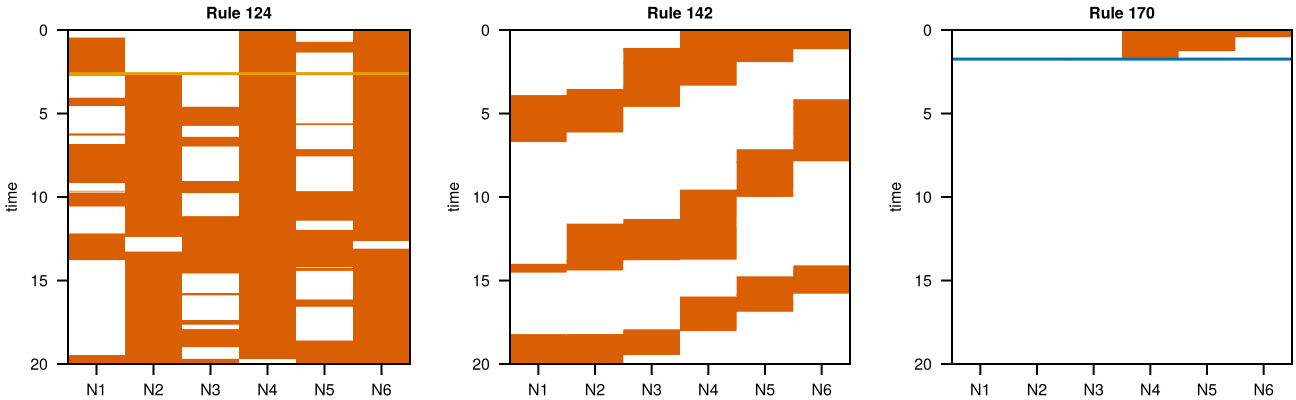

In [50]:
rules = [124, 142, 170]
single_width = double_col_width / 3

f = Figure(;
    size=(length(rules)*single_width, (double_col_width / golden_ratio) / 2),
    fontsize=8,
    figure_padding=2.
)

axs = []
for (i, r) in enumerate(rules)
    ax = Axis(f[1,i])
    push!(axs, ax)
    do_gs_and_kymograph!(ax, 6, r, false, 20, 57;
        usetime=true,
        include_nonsshline=(r != 142),
        # colormap=:BrBG_5,
        colormap=range(colorant"white", MAColors.ligand_1s(), 2),
        # colormap=cgrad(colorant"white", colorant"red"),
        inf_time=20.,
    )
    ax.title = "Rule $r"
    # ylims!(ax, (20, 0))
end

for ax in axs[1:3]
    ylims!(ax, (20, 0))
end

save("../data/figures/kymograph_drafts/fig1_3kymographs.pdf", f)

f

## 142, multiruns

┌ Warning: Note: adding edges with a zero weight to this graph type has no effect.
└ @ SimpleWeightedGraphs ~/.julia/packages/SimpleWeightedGraphs/Ab8wv/src/simpleweighteddigraph.jl:170


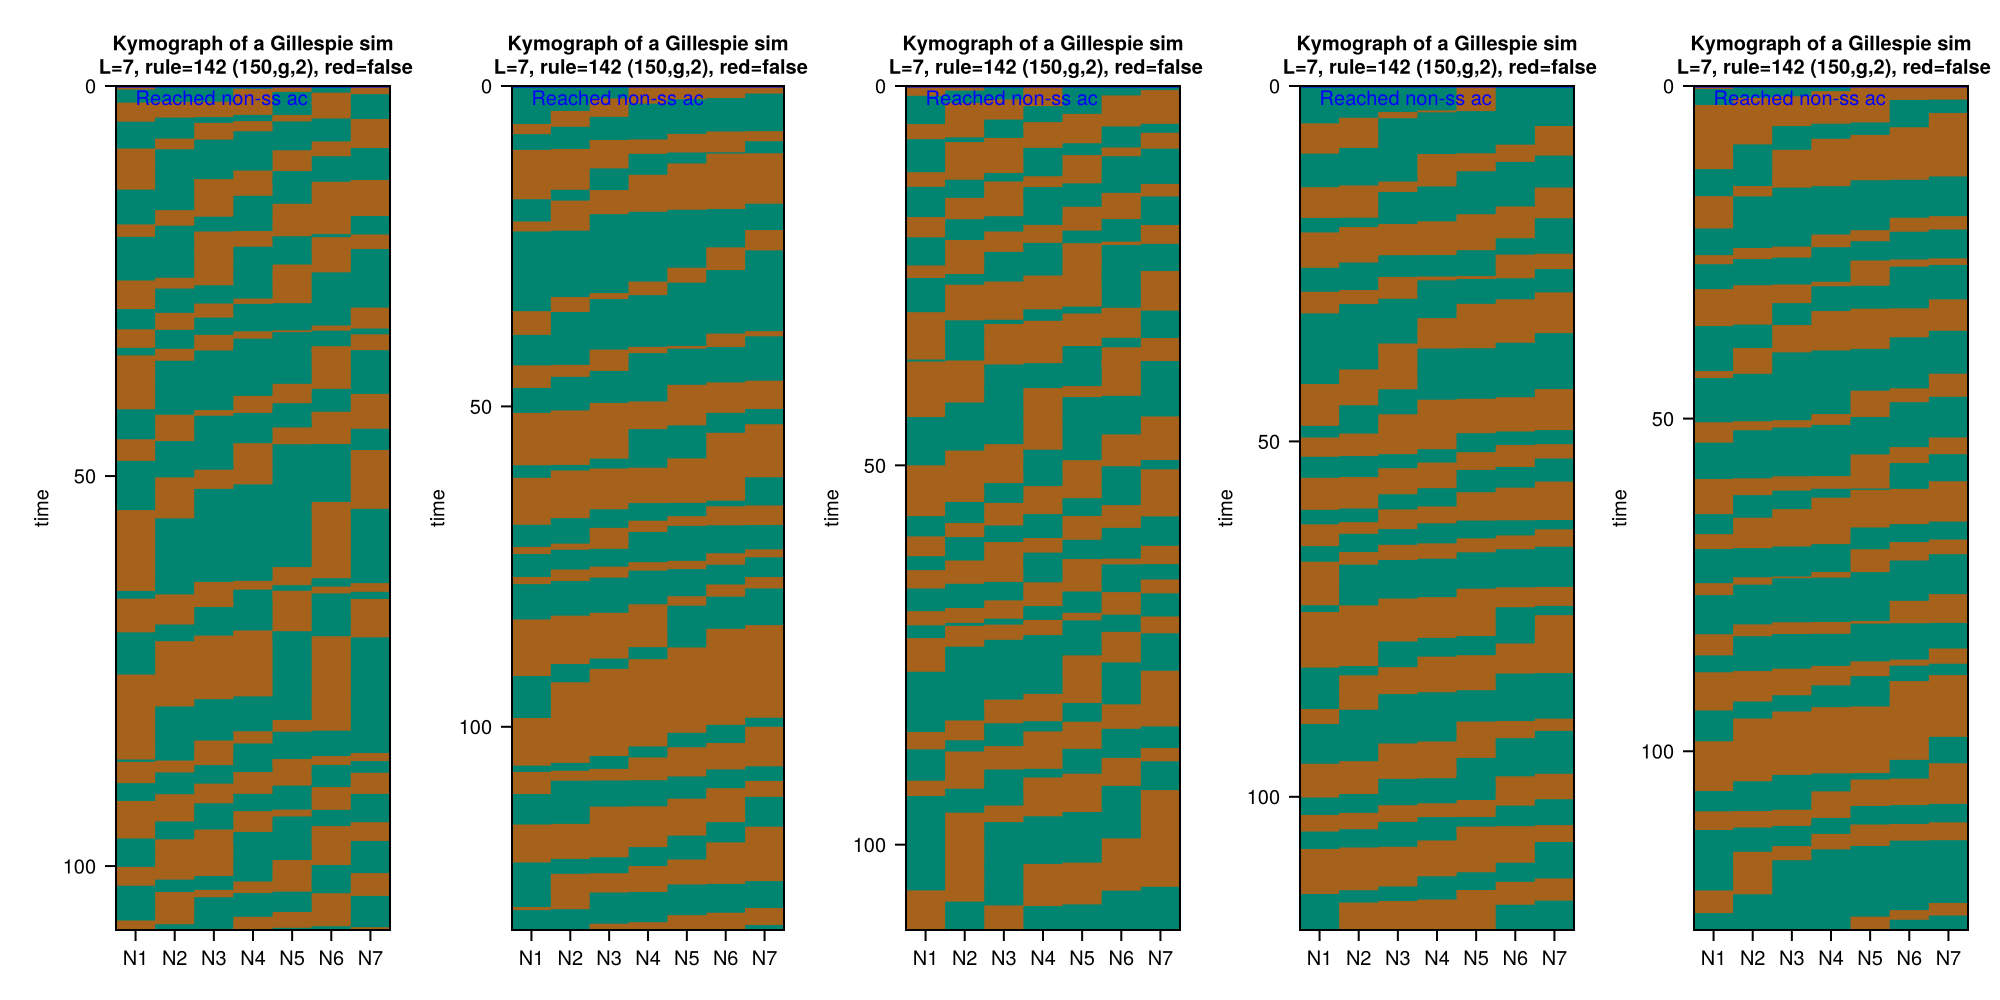

In [13]:
num_runs = 5
single_width = 200

f = Figure(;
    size=(num_runs*single_width, 500),
    fontsize=10,
)

for i in 1:num_runs
    ax = Axis(f[1,i])
    do_gs_and_kymograph!(ax, 7, 142, false, 200, nothing; colormap=:BrBG_5)
end

f

In [1036]:
save("../data/figures/kymograph_drafts/r142_5plots.pdf", f)

CairoMakie.Screen{PDF}


## Many plots

In [1132]:
num_runs = 10
single_width = 200

# for r in [134, 142, 38, 46, 62, 3, 11, 19, 25, 27, 33, 35, 41, 43]
for r in [134, 142, 6, 14, 30, 38, 46, 62, 3, 7, 11, 15, 19, 25, 27, 33, 35, 37, 41, 43, 45]
    for L in [5, 6]
        f = Figure(;
            size=(num_runs*single_width, 500),
            fontsize=10,
        )
        
        ps = []
        for i in 1:num_runs
            ax = Axis(f[1,i])
            p = do_gs_and_kymograph!(ax, L, r, false, 200, nothing; colormap=Categorical(:BrBG_5))
            push!(ps, p)
        end
        Colorbar(f[1,num_runs+1], ps[end])

        save("../data/figures/kymograph_drafts/many1/L$(L)_r$(r).pdf", f)
    end
end

## Max out of eq rules

In [23]:
num_runs = 10
single_width = 200

for r in [255, 250, 95, 245, 240]
    for L in [6]
        f = Figure(;
            size=(num_runs*single_width, 1000),
            fontsize=10,
        )
        
        ps = []
        for i in 1:num_runs
            ax = Axis(f[1,i])
            p = do_gs_and_kymograph!(ax, L, r, false, 10000, nothing; colormap=Categorical(:BrBG_5))
            push!(ps, p)
        end
        Colorbar(f[1,num_runs+1], ps[end])

        save("../data/figures/kymograph_drafts/maxoutofeqrules/L$(L)_r$(r).pdf", f)
    end
end

## Testing

In [33]:
Ks_to_cacode([1 1; 0 1], [1 0; 1 1])

43

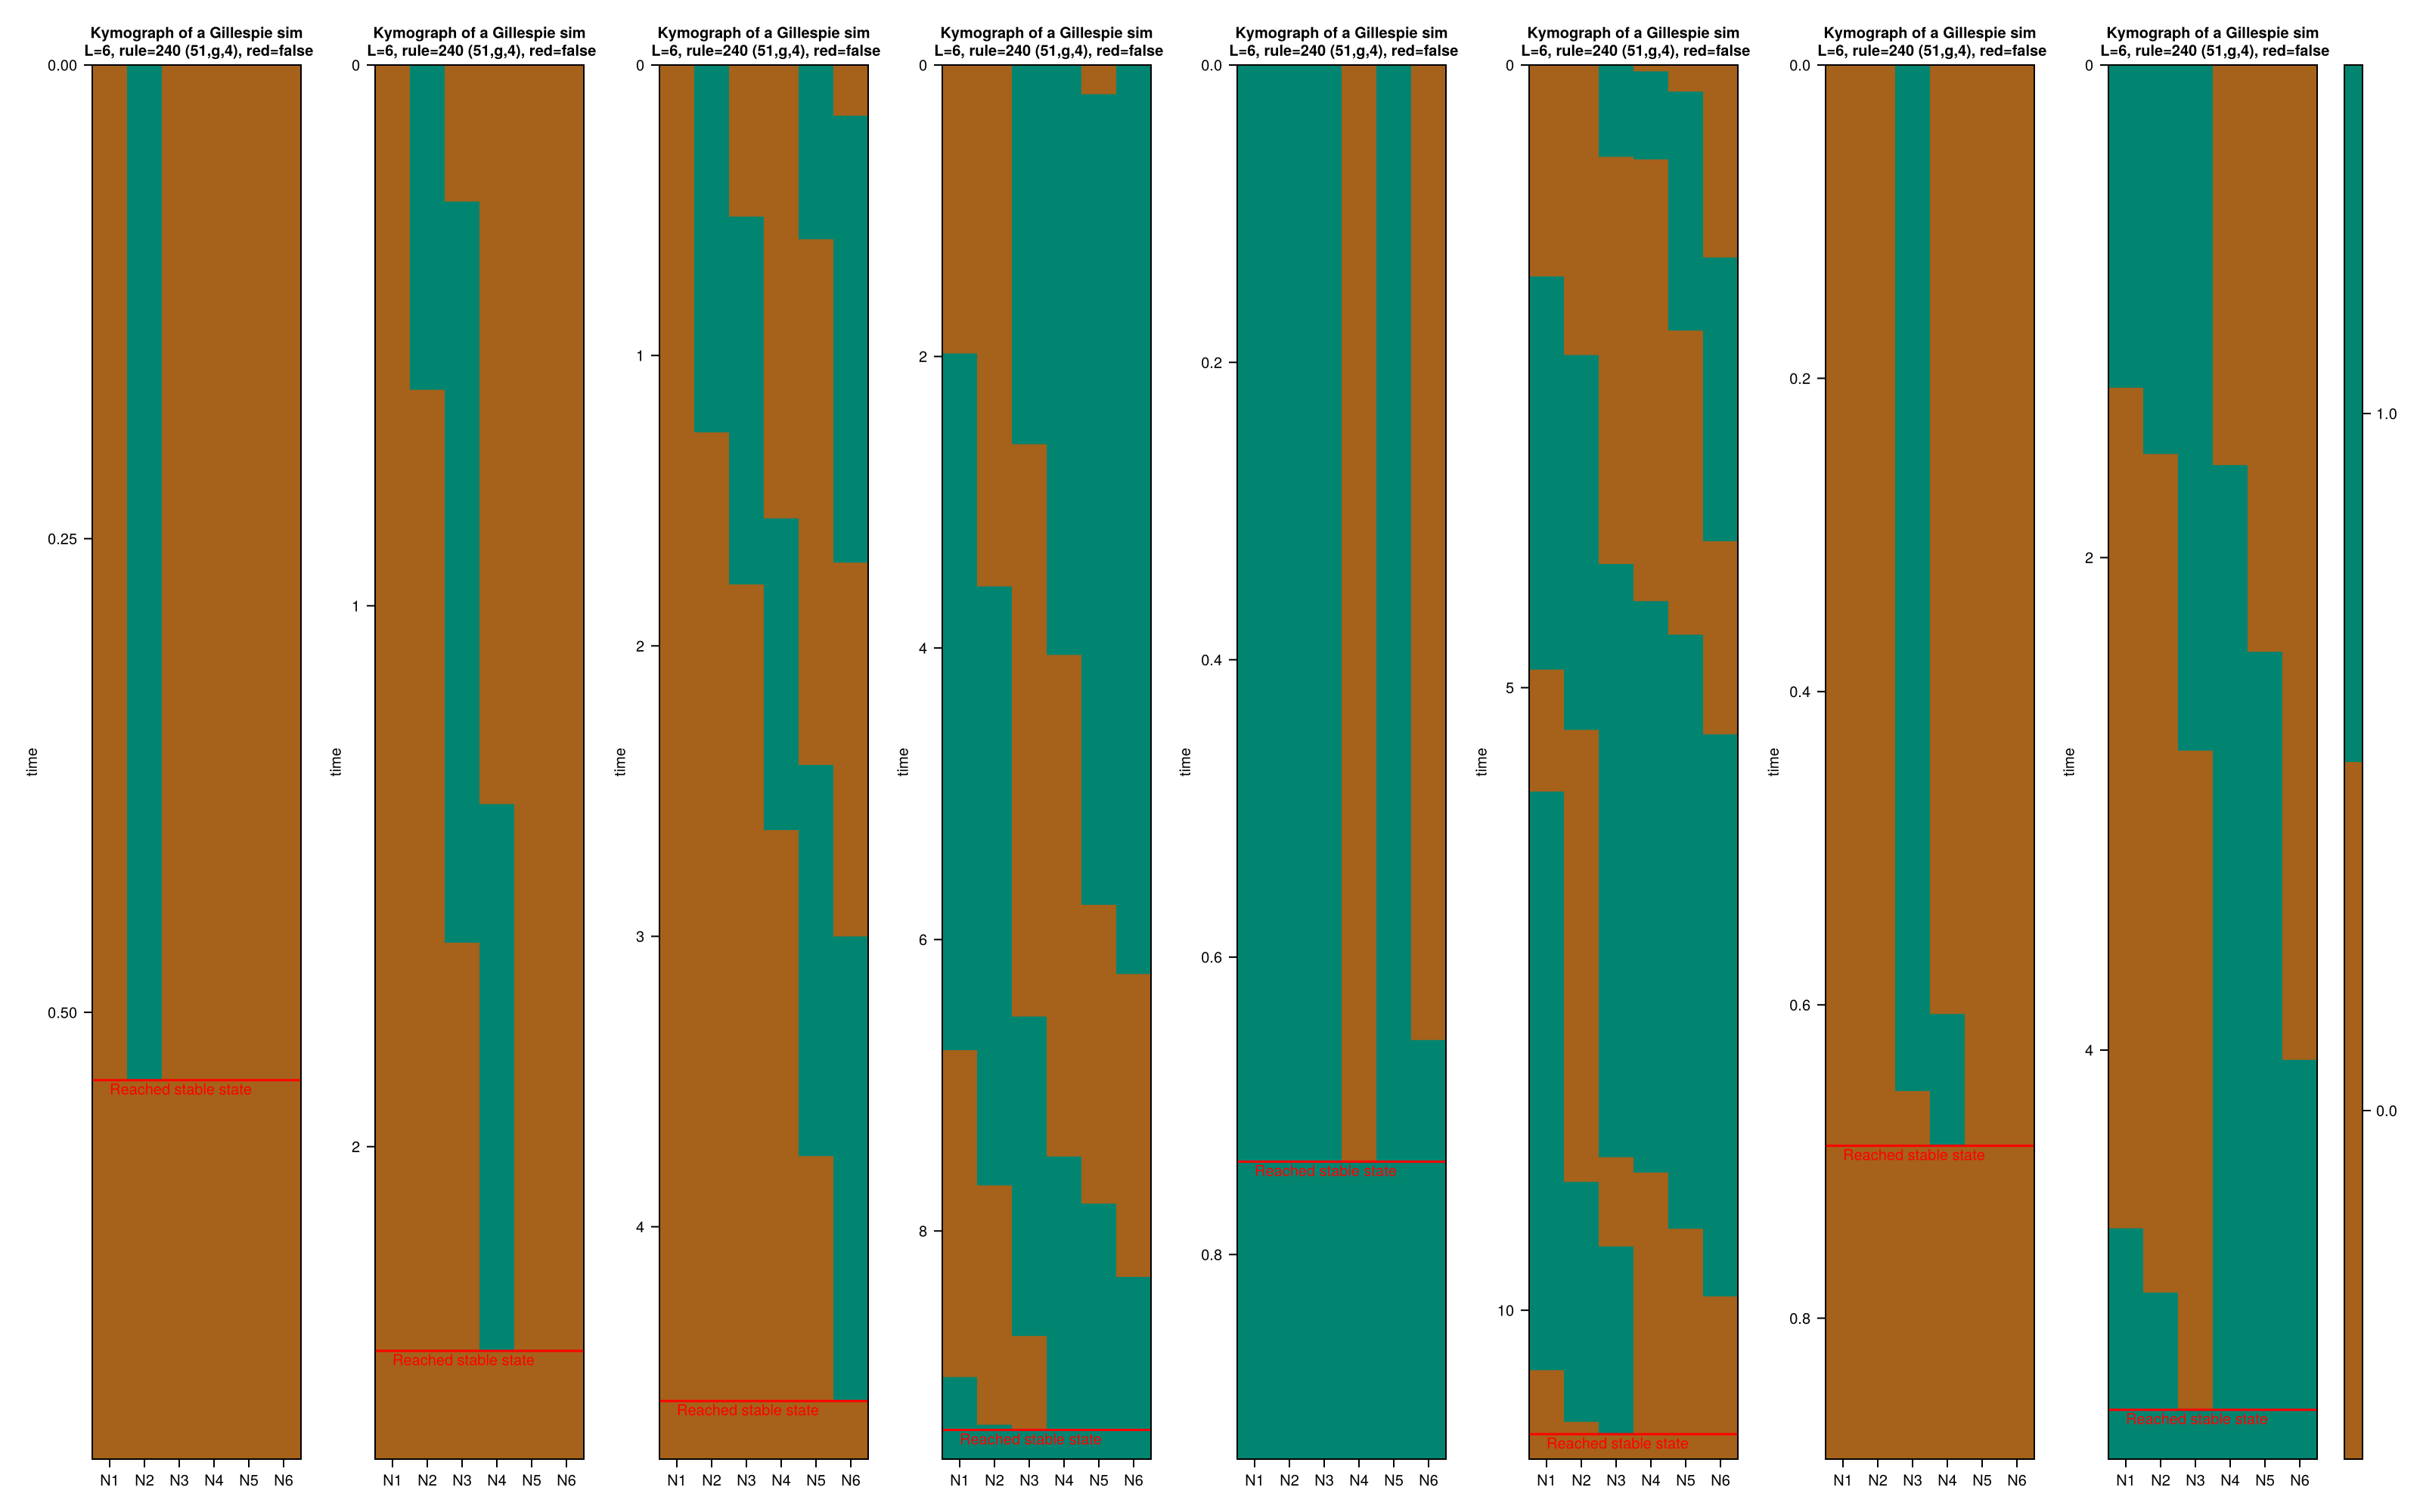

In [59]:
num_runs = 8
single_width = 200

f = Figure(;
    size=(num_runs*single_width, 1000),
    fontsize=10,
)

ps = []
for i in 1:num_runs
    ax = Axis(f[1,i])
    p = do_gs_and_kymograph!(ax, 6, 240, false, 500, nothing; colormap=Categorical(:BrBG_5))
    push!(ps, p)
end
Colorbar(f[1,num_runs+1], ps[end])

f

In [60]:
save("../data/figures/kymograph_drafts/r240_L6.pdf", f)

CairoMakie.Screen{PDF}


## Testing

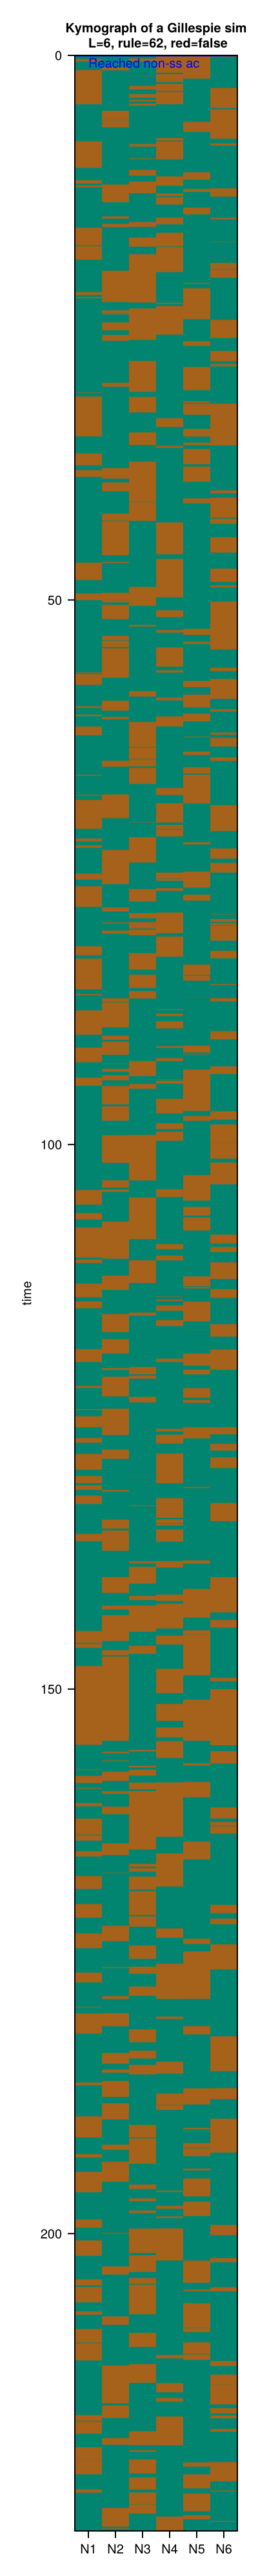

In [1007]:
do_gs_and_kymograph(6, 62, false, 1000, 7; fig=(; size=(200, 2000)), colormap=:BrBG_5)

# Bits and bobs

In [3]:
GC.gc()
empty!(Out)
GC.gc()